In [1]:
import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# Download Data

In [2]:
# Ensure that the github-issues-data volume is mounted in /mnt
!ls -la /mnt

total 0
drwxr-xr-x 2 root root  6 Aug 21  2018 .
drwxr-xr-x 1 root root 40 Feb  1 09:26 ..


In [3]:
# Set path for data dir
%env DATA_DIR=/data

env: DATA_DIR=/data


In [4]:
# Download the github-issues.zip training data to /mnt/github-issues-data
!wget --directory-prefix=${DATA_DIR} https://storage.googleapis.com/kubeflow-examples/github-issue-summarization-data/github-issues.zip

# Unzip the file into /mnt/github-issues-data directory
!unzip ${DATA_DIR}/github-issues.zip -d ${DATA_DIR}

--2021-02-01 10:41:33--  https://storage.googleapis.com/kubeflow-examples/github-issue-summarization-data/github-issues.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 172.253.115.128, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027424178 (980M) [application/zip]
Saving to: ‘/data/github-issues.zip’

github-issues.zip   100%[===================>] 979.83M  6.53MB/s    in 2m 31s  

2021-02-01 10:44:05 (6.48 MB/s) - ‘/data/github-issues.zip’ saved [1027424178/1027424178]

Archive:  /data/github-issues.zip
  inflating: /data/github_issues.csv  


In [5]:
# Create a symlink from <current_directory>/github-issues-data to /mnt/github-issues-data
!ln -sf ${DATA_DIR} github-issues-data

In [6]:
# Make sure that the github-issues-data symlink is created
!ls -lh github-issues-data/github_issues.csv

-rw-r--r-- 1 jovyan users 2.7G Jan 17  2018 github-issues-data/github_issues.csv


# Process Data

Split data into train and test set and preview data

In [7]:
data_file='github-issues-data/github_issues.csv'

# read in data sample 2000 rows (for speed of tutorial)
# Set this to False to train on the entire dataset
use_sample_data=True

if use_sample_data:
    training_data_size=2000
    traindf, testdf = train_test_split(pd.read_csv(data_file).sample(n=training_data_size), 
                                   test_size=.10)
else:
    traindf, testdf = train_test_split(pd.read_csv(data_file),test_size=.10)


#print out stats about shape of data
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

# preview data
traindf.head(3)

Train: 1,800 rows 3 columns
Test: 200 rows 3 columns


,issue_url,issue_title,body
618568,"""https://github.com/topcoder-platform/community-app/issues/18""",font loading issue in dev,"loading fonts as separate files in dev leads to problems with hmr. i've changed it to load fonts as data urls within js bundle. this solves the problem with hmr, but delays proper rendering of page in dev environment. should be further investigated and fixed."
2121387,"""https://github.com/LoungeBuddy/Test/issues/18""",foursquare api integration with ios app to allow app users access to more lounge reviews and photos.,"summary foursquare api integration with ios app to allow app users access to more lounge reviews and photos. steps 1. select lounge. 2. on lounge ui, scroll down to lounge reviews section. 3. next to ‘add a review’ and ‘view all’ buttons, add a foursquare icon/button. 4. on clicking foursquare icon, user is taken directly to the lounge’s page on foursquare. additional notes - numerous airline lounges have extensive reviews on foursquare - location of the foursquare icon is subject to ab test..."
2656821,"""https://github.com/SeleniumHQ/selenium/issues/4645""",dotnet - attempt to save a screenshot to a directory which does not exist throw a cryptic generic gdi error,"meta - os: windows selenium version: 3.5.1 browser: any browser version: any when we try to save a screenshot to a directory which does not exist, it throws with the following error: a generic error occurred in gdi+ expected behavior - it should either create the directory or throw an explicit directorynotfoundexception actual behavior - it throws a cryptic generic gdi exception steps to reproduce - add the following to an existing test csharp var testscreenshotpath = c:\\pathtoadirectorywhi..."


**Convert to lists in preparation for modeling**

In [8]:
train_body_raw = traindf.body.tolist()
train_title_raw = traindf.issue_title.tolist()
#preview output of first element
train_body_raw[0]

"loading fonts as separate files in dev leads to problems with hmr. i've changed it to load fonts as data urls within js bundle. this solves the problem with hmr, but delays proper rendering of page in dev environment. should be further investigated and fixed."

# Pre-Process Data For Deep Learning

See [this repo](https://github.com/hamelsmu/ktext) for documentation on the ktext package

In [9]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [10]:
#%%time
# Clean, tokenize, and apply padding / truncating such that each document length = 70
#  also, retain only the top 8,000 words in the vocabulary and set the remaining words
#  to 1 which will become common index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

#### Look at one example of processed issue bodies

In [11]:
print('\noriginal string:\n', train_body_raw[0], '\n')
print('after pre-processing:\n', train_body_vecs[0], '\n')


original string:
 loading fonts as separate files in dev leads to problems with hmr. i've changed it to load fonts as data urls within js bundle. this solves the problem with hmr, but delays proper rendering of page in dev environment. should be further investigated and fixed. 

after pre-processing:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  758 1470   24 1190
  103    7  335 1366    4  657   19 4477    6  224  636   10    4  315
 1470   24   62 1121  509   60  950   13 4478    3  126   19 4477   25
 3503 2170  806   11  115    7  335  247   38   15 1941 4479    9  437] 



In [12]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=12, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

#### Look at one example of processed issue titles

In [13]:
print('\noriginal string:\n', train_title_raw[0])
print('after pre-processing:\n', train_title_vecs[0])


original string:
 font loading issue in dev
after pre-processing:
 [  2 255 365  20   6 221   3   0   0   0   0   0]


Serialize all of this to disk for later use

In [14]:
import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

# Define Model Architecture

### Load the data from disk into variables

In [15]:
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

In [16]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs.npy')

Shape of encoder input: (1800, 70)
Shape of decoder input: (1800, 11)
Shape of decoder target: (1800, 11)


In [17]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 8002
Size of vocabulary for title_pp.dpkl: 4254


### Define Model Architecture

In [18]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

In [19]:
#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 300

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

########################
#### Seq2Seq Model ####

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

** Examine Model Architecture Summary **

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1276200     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
____________________________________________________________________________________________

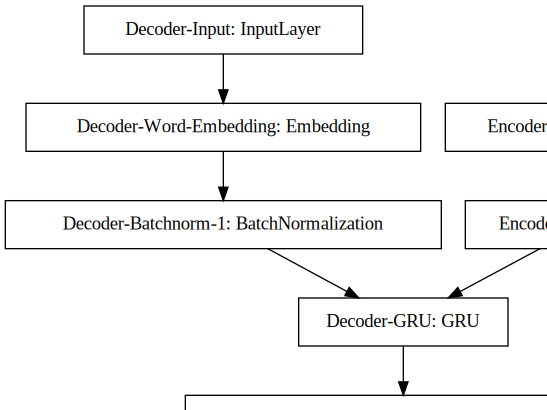

In [20]:
from seq2seq_utils import viz_model_architecture
seq2seq_Model.summary()
viz_model_architecture(seq2seq_Model)

# Train Model

In [21]:
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 7
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 1584 samples, validate on 216 samples
Epoch 1/7
1584/1584 [==============================] - 7s 4ms/step - loss: 8.1897 - val_loss: 7.1236
Epoch 2/7
1584/1584 [==============================] - 6s 4ms/step - loss: 6.9765 - val_loss: 6.4204
Epoch 3/7
1584/1584 [==============================] - 6s 4ms/step - loss: 6.2519 - val_loss: 5.9892
Epoch 4/7
1584/1584 [==============================] - 6s 4ms/step - loss: 5.7648 - val_loss: 5.6660
Epoch 5/7
1584/1584 [==============================] - 6s 4ms/step - loss: 5.3693 - val_loss: 5.4416
Epoch 6/7
1584/1584 [==============================] - 6s 4ms/step - loss: 5.0281 - val_loss: 5.2472
Epoch 7/7
1584/1584 [==============================] - 6s 4ms/step - loss: 4.7387 - val_loss: 5.1499


In [22]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial.h5')

# See Example Results On Holdout Set

It is useful to see examples of real predictions on a holdout set to get a sense of the performance of the model.  We will also evaluate the model numerically in a following section.

In [23]:
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [24]:
# this method displays the predictions on random rows of the holdout set
seq2seq_inf.demo_model_predictions(n=50, issue_df=testdf)



============== Example # 161 =================

"https://github.com/dyweb/gommon/issues/7"
Issue Body:
 found it when using prometheus - https://github.com/prometheus/common/blob/master/log/log.go l240 

Original Title:
 log support source line number

****** Machine Generated Title (Prediction) ******:
 make fix crash in


============== Example # 21 =================

"https://github.com/guyb7/time-prices/issues/5"
Issue Body:
 unnecessary listeners are left behind on sites with constant dom changes single-page-apps , may cause memory leaks. 

Original Title:
 remove listeners from destroyed elements

****** Machine Generated Title (Prediction) ******:
 first from flow in uk south


============== Example # 26 =================

"https://github.com/exercism/xlua/issues/187"
Issue Body:
 this appears to be due to a point update 5.3.3 => 5.3.4 changing a check around __tostring . 

Original Title:
 minesweeper sample fails ci

****** Machine Generated Title (Prediction) ******:
 add 


****** Machine Generated Title (Prediction) ******:
 first from flow in uk south


============== Example # 163 =================

"https://github.com/18F/fec-transition/issues/161"
Issue Body:
 so users can access classic.fec.gov after we shutdown our waltham data center, we should host classic.fec.gov in an in alternative hosting center. 

Original Title:
 create environment for classic.fec.gov

****** Machine Generated Title (Prediction) ******:
 make add not working


============== Example # 28 =================

"https://github.com/ksAutotests/CreateInvalidAndUpdateInvalidTest/issues/340"
Issue Body:
 tutorial issue found: https://github.com/ksautotests/createinvalidandupdateinvalidtest/blob/master/tutorials/firefox/tutorial_firefox.md https://github.com/ksautotests/createinvalidandupdateinvalidtest/blob/master/tutorials/firefox/tutorial_firefox.md contains invalid primary tag.
your tutorial was not created. please double-check primary tag property. each tutorial md-file shall h


****** Machine Generated Title (Prediction) ******:
 add not working


============== Example # 22 =================

"https://github.com/skeeto/elfeed/issues/204"
Issue Body:
 today i accidently pressed c-x w and g to download new content while wifi was offf and it returned successfully. i was hoping for a message or a beep. 

Original Title:
 elfeed should show some kind of error notification if the remote feed url was not accessible

****** Machine Generated Title (Prediction) ******:
 make fix crash in


============== Example # 127 =================

"https://github.com/vividvilla/csvtotable/issues/25"
Issue Body:
 would it be possible for the next version to include in the final html a line <!-- this file was made by csvtotable https://github.com/vividvilla/csvtotable --> ? knowlegeable visitors to my pages have been asking me how it was done ... 

Original Title:
 this file was made by

****** Machine Generated Title (Prediction) ******:
 first from flow in uk south


=========


****** Machine Generated Title (Prediction) ******:
 first from flow in uk south


============== Example # 151 =================

"https://github.com/rdlabo/ionic-wpcom/issues/3"
Issue Body:
 hello it is possible to add custom post or page link in menu? thanks 

Original Title:
 custom post or page link in menu

****** Machine Generated Title (Prediction) ******:
 add not working


============== Example # 173 =================

"https://github.com/craftercms/craftercms/issues/632"
Issue Body:
 the application is not updating the counter of comments of the “view and comment” icon when the user delete a comment - user need to refresh the page. preconditions: ==================== reproducibility level: ==================== always steps: ==================== steps 1. log into the application with valid credentials 2. go to a page with social content enabled. 3. add a comment. 4.verify the counter of the view and comment icon increase in 1. 5.delete the previous created comment. current 

# Evaluate Model: BLEU Score

For machine-translation tasks such as this one, it is common to measure the accuracy of results using the [BLEU Score](https://en.wikipedia.org/wiki/BLEU).  The convenience function illustrated below uses [NLTK's corpus_bleu](https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.corpus_bleu).  The output of the below convenience function is an Average of BlEU-1, BLEU-2, BLEU-3 and BLEU-4. 

In [25]:
#convenience function that generates predictions on holdout set and calculates BLEU Score

bleu_score = seq2seq_inf.evaluate_model(holdout_bodies=testdf.body.tolist(), 
                                        holdout_titles=testdf.issue_title.tolist(), 
                                        max_len_title=12)

In [26]:
print(f'BLEU Score (avg of BLUE 1-4) on Holdout Set: {bleu_score * 100}')

BLEU Score (avg of BLUE 1-4) on Holdout Set: 3.053487322442532
